In [1]:
import pandas as pd
from espnff import League
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [51]:
# connection
cred = pd.read_csv("/Users/patrick.chen/Desktop/espn_cred.csv")
league = League(749478,
                2018,
                espn_s2=cred['espn2'][0],
                swid=cred['swid'][0])

# Standings Table

In [52]:
team_name = []
standings =[]
for i in range(12):
    team = league.teams[i]
    team_name.append(team.team_name)
    standings.append(str(team.wins)+"-"+str(team.losses))

team_standings = pd.DataFrame({'team':team_name,'standings':standings})

# Scores Table

In [53]:
scores = []
team_name = []
opp = []
week= ['Week 1','Week 2','Week 3','Week 4','Week 5','Week 6','Week 7',
       'Week 8','Week 9','Week 10','Week 11','Week 12','Week 13']*12
for i in range(12):
    team = league.teams[i]
    opp = opp+team.schedule
    scores = scores + team.scores
    for i in range(13):
        team_name.append(team.team_name)

In [54]:
for i in [scores,team_name,opp,week]:
    print(len(i))

156
156
156
156


In [55]:
df = pd.DataFrame({'Team':team_name,
                   'Week':week,
                   'Score':scores,
                   'Opp':opp})

In [56]:
df['Opp'] = df.Opp.astype(str).str.replace('Team(', '', regex=False).str.strip(")")

In [57]:
df2 = df.copy().drop('Opp',axis=1)

In [58]:
df2.columns = ['Opp','Week','Opp_Score']

In [59]:
df3 = df.merge(df2,on=['Opp','Week'])

In [60]:
df3['margin'] = df3.Score-df3.Opp_Score

In [61]:
names = df3.Team.unique().tolist()

In [62]:
# create lists
lost_margin = []
win_margin = []
avg = []
std = []
for n in names:
    avg.append(df3[(df3.Team==n)].Score.mean())
    std.append(df3[(df3.Team==n)].Score.std())
    lost_margin.append(df3[(df3.Team==n)&(df3.margin<0)].margin.mean())
    win_margin.append(df3[(df3.Team==n)&(df3.margin>0)].margin.mean())

In [63]:
# create df
df4 = pd.DataFrame(data={'team':names,
                   'avg_score':avg,
                   'std':std,
                   'win_margin':win_margin,
                   'lost_margin':lost_margin
                  })

In [64]:
df5 = df4.merge(team_standings, on ='team')

In [65]:
df5 = df5.sort_values(['standings','avg_score'],ascending=True)

In [66]:
columns = ['avg_score','std','win_margin','lost_margin']
titles = ['Average Score (mean)','BOOM or BUST (std)', 'Barely Won a Game (Win Margin)', 'Almost Won a Game (Loss Margin)']
standings = df5.standings.unique().tolist()

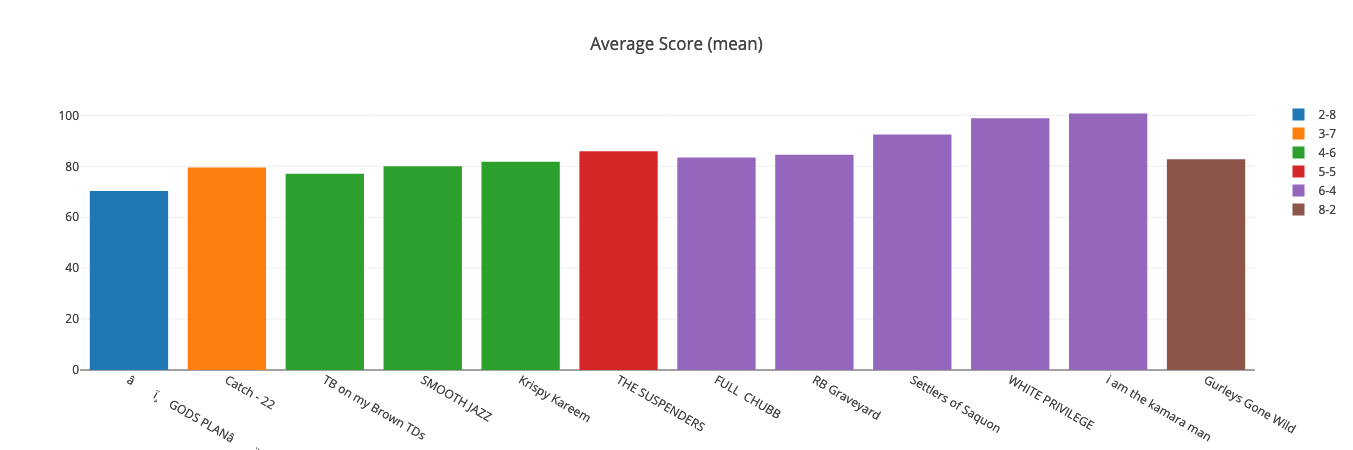

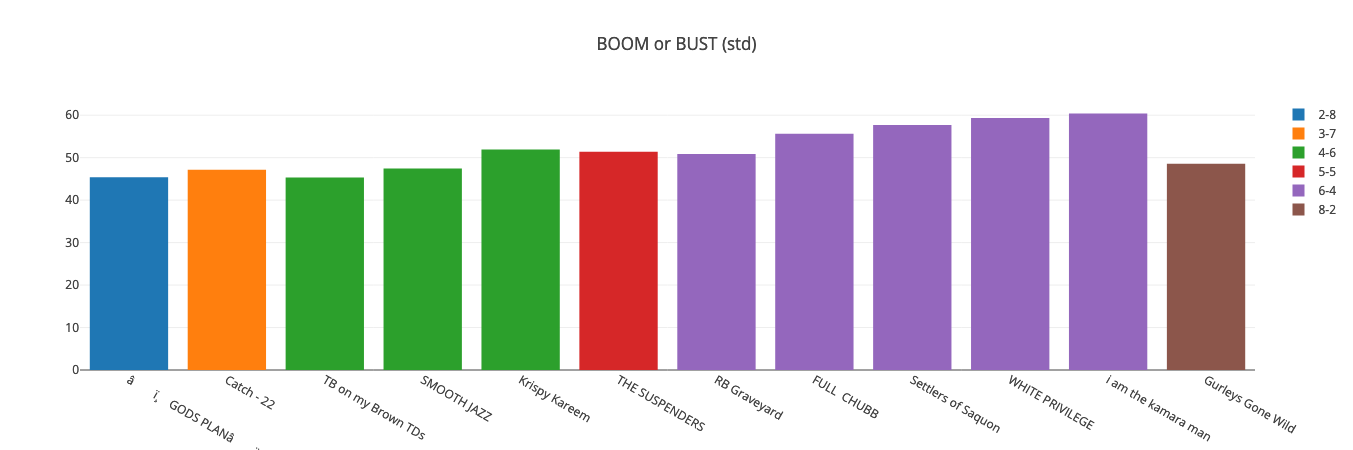

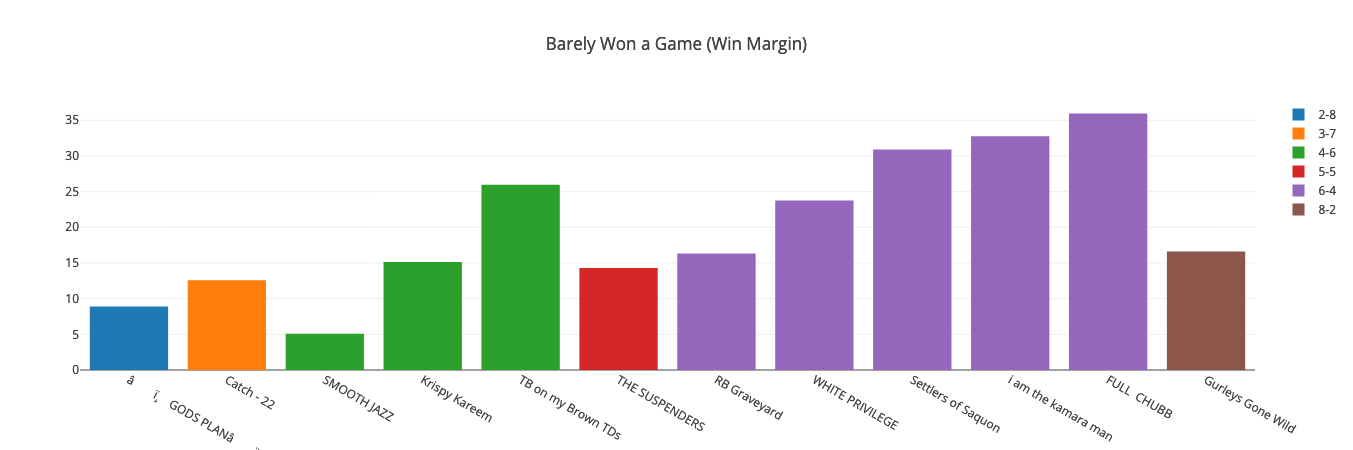

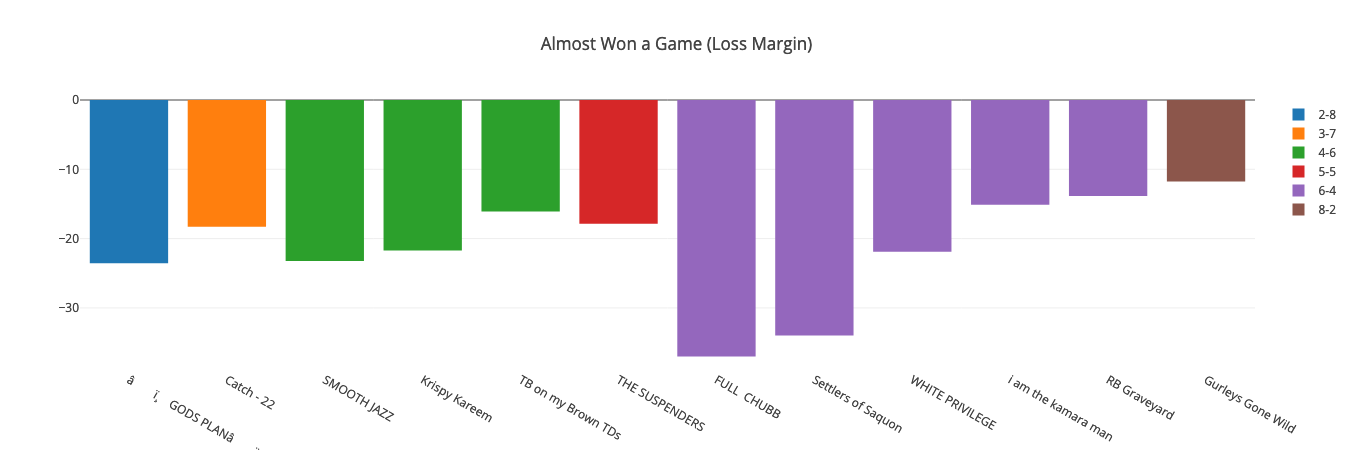

In [67]:
# create graph
for col,title in zip(columns,titles):
    df6 = df5.sort_values(col)

    # trace
    data = []
    for s in standings:
        trace = go.Bar(x=df6[df6.standings==s].team.tolist(),
                       y=df6[df6.standings==s][col].tolist(),name=s)
        data.append(trace)

    #layout
    layout = go.Layout(title=title,
                       barmode='group')

    # fig
    fig = go.Figure(data=data, layout=layout)
    
    py.iplot(fig)